
# **Optimisation de portfeuil**

## **Introduction**

Nous alons utiliser la methodologie *esperance-variance* pour optimiser deux portfeuils.

*   **Le premier :** un portfeuil qui contient  5 actifs risqués sur le **NASDAQ** avec le meilleur score **ESG = AAA**.

*    **Le deuxieme :** un portfeuil qui contient 5 actifs risqués sur le **NASDAQ** avec le pire score **ESG = CCC**.


On prend également un troisième port feuil qui contient des entreprises avec beaucoup de liquidité pour comparer. 

In [ ]:
from datetime import datetime
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import *
import scipy.integrate as integrate

In [ ]:
from tvDatafeed import TvDatafeed, Interval

In [ ]:
!pip install tvDatafeed

In [ ]:
logging.basicConfig(level=logging.DEBUG)

In [ ]:
import time
import warnings
warnings.filterwarnings('ignore')

from selenium import webdriver
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [ ]:
tv=TvDatafeed(auto_login=True, chromedriver_path="C:\webdrivers\chromedriver.exe")

In [ ]:
data_RF=tv.get_hist('GB01Y','TVC',Interval.in_1_hour,n_bars=5000)#,fut_contract=1)

## **Extraction des données**

Nous allons utiliser la bibliothèque  *tvDatafeed*

In [ ]:
#data_RF=tv.get_hist('GB01Y','TVC',Interval.in_1_hour,n_bars=5000)#,fut_contract=1)


asets=['FB','AMZN','NFLX','AAPL','GOOG']  
asets_C=['SATS','XRX','FOX','CMCSA','NWSA']
asets_A=['MSFT','JBHT','NVDA','QCOM','TXN']

markets=[]

dfs_name=['data_'+ast for ast in asets]
dfs_name_C=['data_'+ast for ast in asets_C]
dfs_name_A=['data_'+ast for ast in asets_A]

dfs_names=dfs_name.copy()
dfs_names.append('data_RF')

dfs_names_C=dfs_name_C.copy()
dfs_names_C.append('data_RF')

dfs_names_A=dfs_name_A.copy()
dfs_names_A.append('data_RF')



print(dfs_name)
i=0
for ast in asets_C:
  
  str = dfs_name_C[i]
  print(str)
  locals()[str] = tv.get_hist(ast,'NASDAQ',Interval.in_1_hour,n_bars=5000)#,fut_contract=1)
  i=i+1


j=0

for ast in asets_A:
  
  str = dfs_name_A[j]
  print(str)
  locals()[str] = tv.get_hist(ast,'NASDAQ',Interval.in_1_hour,n_bars=5000)#,fut_contract=1)
  j=j+1



t=0

for ast in asets:
  
  str = dfs_name[t]
  print(str)
  locals()[str] = tv.get_hist(ast,'NASDAQ',Interval.in_1_hour,n_bars=5000)#,fut_contract=1)
  t=t+1





## Traitement des données



In [ ]:

def traitement_df(df):

  colums=['open',	'high',	'low',	'close',	'volume']

  for name in colums:
    col=df[name]
    
    dif_=[0]
    

    for i in range(1,len(col)):
      dif_.append((col[i]-col[i-1]))

    
    df[name+'log_dif']=df[name].pct_change().apply(lambda x: 100*np.log(1+x))


    df[name+'dif_']=np.array(dif_)
   
    df[name+'dif_abs']=np.abs(np.array(dif_))
    


    df[name+'_n']=np.array(df[name])/max(df[name])
  


 

In [ ]:
for df_name in dfs_name_C+dfs_name_A+dfs_name:

  traitement_df(locals()[df_name])


traitement_df(data_RF)

In [ ]:
for df_name in dfs_name_C+dfs_name_A+dfs_name:

  print(df_name,len(locals()[df_name]))

data_SATS 5000
data_XRX 5000
data_FOX 5000
data_CMCSA 5000
data_NWSA 5000
data_MSFT 5000
data_JBHT 5000
data_NVDA 5000
data_QCOM 5000
data_TXN 5000
data_FB 5000
data_AMZN 5000
data_NFLX 5000
data_AAPL 5000
data_GOOG 5000


In [ ]:
def plotats(df,name,TS=False):
  col_n=name

  warnings.filterwarnings('ignore')
  


  if TS:
    df[col_n].plot()
  
  fig, ax = plt.subplots()



  sns.histplot(x=col_n, weights="volume", data=df, bins=150, ax=ax)
  
  warnings.filterwarnings('ignore')

  ax.set_xlabel(col_n)
  ax.set_ylabel("volume")
  warnings.filterwarnings('ignore')
  plt.show()

  warnings.filterwarnings('ignore')

  plot_acf(df[col_n],lags=1,title='auto_cor_'+col_n)
  warnings.filterwarnings('ignore')
  plt.show()
  warnings.filterwarnings('ignore')

  plot_pacf(df[col_n], lags=1,title='par_auto_cor_'+col_n)
  plt.show()
  warnings.filterwarnings('ignore')

      

    

## **Exploration des données**

On note $(t_i)_i$ la discrétisation du temps, et on défini
$$Z_i=P_i-P_{i-1}$$








On peut voir dans ce qui suit que $Z_1,....,Z_n$ sont independants

On estime la densite de $Z$ qui suit la même lois que l'échantillon en utilisant le noyau gaussien:
$$K(u)=\frac{1}{\sqrt{2\pi}}e^{-\frac{u^2}{2}}$$
 par: 
<!-- 
$$ \hat{f}_{n,h}(x_0)=\frac{1}{nh}\sum_{i=1}^nK\left(\frac{X_i-x_0}{h}\right $$  -->


$$\hat{f}_{n,h}(x_0)=\frac{1}{nh}\sum_{i=1}^nK\left(\frac{Z_i-x_0}{h}\right)$$

On a
$$MISE(\hat{f}_{n,h})=\mathbb{E}\left[ \int\hat{f}_{n,h}^2(x)\,dx -2\int \hat{f}_{n,h}(x)f(x)\,dx +\int f^2(x)\,dx\right]$$

On remarque alors que minimiser $ MISE $ en $ h $ revient à minimiser en h:
$$\mathcal{I}_h=\mathbb{E}\left[ \int\hat{f}_{n,h}^2(x)\,dx\right ] -2\mathbb{E}\left[\int \hat{f}_{n,h}(x)f(x)\,dx\right]$$
Par ailleur, $\int\hat{f}_{n,h}^2(x)\,dx$ est un éstimateur sans biais de $\mathbb{E}\left[ \int\hat{f}_{n,h}^2(x)\,dx\right ]$.

On va donc chercher un éstimateur sans biais de $\mathbb{E}\left[\int \hat{f}_{n,h}(x)f(x)\,dx\right]$, cela revient a chercher un éstimateur de $\mathbb{E}\left[ \hat{f}_{n,h}(Z)\right ]$, ou $Z$ est indépendant de $(Z_1,...,Z_n)$.

En effet,

$$\mathbb{E}_{_{(Z_1,...,Z_n)}}\left[\hat{f}_{n,h}(Z)\right]=\mathbb{E}_{_{(Z_1,...,Z_n)}}\left[\mathbb{E}_{_{Z}}[\hat{f}_{n,h}(Z)\mid Z_1,..,Z_n]\right]=\mathbb{E}_{_{(Z_1,...,Z_n)}}\left[\int \hat{f}_{n,h}(x)f(x)\,dx\right]$$
Vu que $\left(\hat{f}_{n,h}(Z_i)\right)_{i\leq n}$ ne sont pas i.i.d, on ne pourrais pas utiliser $\frac{1}{n}\sum_{i=1}^n\hat{f}_{n,h}(Z_i)$ comme éstimateur.

On va s'appuier sur le *leave-one-out* pour pallier à ce problème, on definit alors pour $i\in\{1,...,n\}$
$$\hat{f}_{n,h}^{(-i)}(x_0)=\frac{1}{(n-1)h}\sum_{j=1,j\neq i}^nK\left(\frac{Z_j-x_0}{h}\right)$$



On alors,
$$\mathbb{E}\left[\int \hat{f}_{n,h}(x)f(x)\,dx\right]=\mathbb{E}\left[\frac{1}{n}\sum_{i=1}^n\hat{f}_{n,h}^{(-i)}(Z_i)\right]$$
En effect $\left(\hat{f}_{n,h}^{(-i)}(Z_i)\right)_{i\leq n}$ sont i.i.d, donc $\mathbb{E}\left[\frac{1}{n}\sum_{i=1}^n\hat{f}_{n,h}^{(-i)}(Z_i)\right]=\mathbb{E}\left[\hat{f}_{n,h}^{(-1)}(Z_1)\right]$. 
D'une parts on a :

$$\mathbb{E}\left[\hat{f}_{n,h}^{(-1)}(Z_1)\right]=\mathbb{E}\left[\frac{1}{(n-1)h}\sum_{j=2}^nK\left(\frac{Z_j-Z_1}{h}\right)\right]=\frac{1}{h}\mathbb{E}\left[K\left(\frac{Z_2-Z_1}{h}\right)\right]$$

D'autre part,
$$\mathbb{E}\left[ \hat{f}_{n,h}(Z)\right ]=\mathbb{E}\left[\frac{1}{nh}\sum_{i=1}^nK\left(\frac{Z_i-Z}{h}\right)\right]=\frac{1}{h}\mathbb{E}\left[K\left(\frac{Z_1-Z}{h}\right)\right]$$
Donc,

$$\mathbb{E}\left[ \hat{f}_{n,h}(Z)\right ]=\mathbb{E}\left[\int \hat{f}_{n,h}(x)f(x)\,dx\right]=\mathbb{E}\left[\frac{1}{n}\sum_{i=1}^n\hat{f}_{n,h}^{(-i)}(Z_i)\right]$$
On abouti alors au critère pratique suivant:

$$\hat{h}\in \underset{h\geq0}{argmin}\left(\int\hat{f}_{n,h}^2(x)\,dx-\frac{2}{n}\sum_{i=1}^n\hat{f}_{n,h}^{(-i)}(Z_i)\right)$$

In [ ]:
def noyau_gaussian(x):
  return( (1/sqrt(2*pi))*exp(-(x**2)/2)) 

In [ ]:
noyau_gaussian(10000)

0.0

In [ ]:

def estimateur_noyau_gaussian(x_0,Dn,h):

  col=Dn
  sm=np.array([noyau_gaussian((col[i]-x_0)/h) for i in range(len(col))])
  return(np.mean(sm))




In [ ]:
def distribution_plot(Df,name):

  warnings.filterwarnings('ignore')
  
  D=np.array(Df[name])

  x_=np.linspace(min(D),max(D),5000)
  fx_=[estimateur_noyau_gaussian(x_[i],D[0:],5*np.std(D)/len(D))for i in range(len(x_))]

  plt.plot(x_,fx_)
  warnings.filterwarnings('ignore')
  plt.show()
  warnings.filterwarnings('ignore')


In [ ]:
data_AAPL.columns

Index(['symbol', 'open', 'high', 'low', 'close', 'volume', 'openlog_dif',
       'opendif_', 'opendif_abs', 'open_n', 'highlog_dif', 'highdif_',
       'highdif_abs', 'high_n', 'lowlog_dif', 'lowdif_', 'lowdif_abs', 'low_n',
       'closelog_dif', 'closedif_', 'closedif_abs', 'close_n', 'volumelog_dif',
       'volumedif_', 'volumedif_abs', 'volume_n'],
      dtype='object')

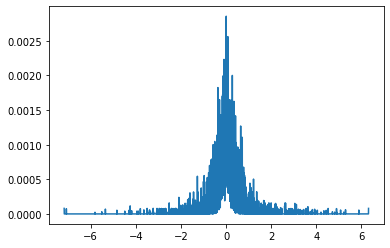

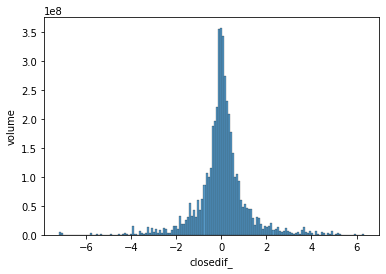

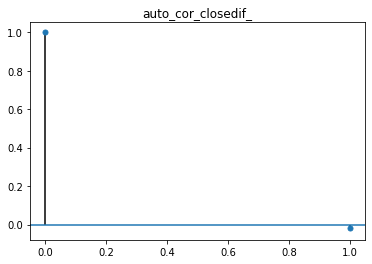

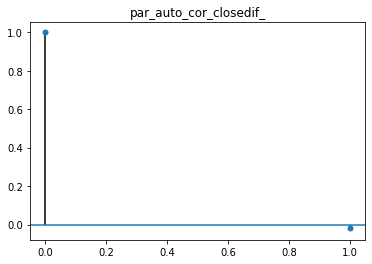

In [ ]:
distribution_plot(data_AAPL,'closedif_')

plotats(data_AAPL,'closedif_')

## **Construction de portefeuilles**

In [ ]:
por_foyo_c=pd.DataFrame(data_RF['close'])
for dfn in dfs_name_C:
  df=locals()[dfn].copy()
  #print(df['close'])
  por_foyo_c[dfn]=np.array(df['close'])




por_foyo_c=por_foyo_c.drop(columns='close')

In [ ]:
por_foyo_c

,data_SATS,data_XRX,data_FOX,data_CMCSA,data_NWSA
datetime,,,,,
2020-10-23 07:00:00,32.823672,30.610,34.28,40.720,11.365
2020-10-23 08:00:00,32.685961,30.980,33.37,41.140,11.390
2020-10-23 09:00:00,32.556352,31.020,33.59,41.070,11.450
2020-10-23 10:00:00,32.677861,30.870,33.61,41.010,11.450
2020-10-23 11:00:00,32.580653,31.080,33.67,40.950,11.380
...,...,...,...,...,...
2022-04-04 17:00:00,24.940000,19.515,36.21,47.865,22.100
2022-04-04 22:00:00,24.920000,19.490,36.20,47.950,22.075
2022-04-04 23:00:00,25.040000,19.490,36.25,48.180,22.060


In [ ]:
por_foyo_a=pd.DataFrame(data_RF['close'])
for dfn in dfs_name_A:
  df=locals()[dfn].copy()
  #print(df['close'])
  por_foyo_a[dfn]=np.array(df['close'])
  
por_foyo_a=por_foyo_a.drop(columns='close')


In [ ]:
por_foyo=pd.DataFrame(data_RF['close'])
for dfn in dfs_name:
  df=locals()[dfn].copy()
  #print(df['close'])
  por_foyo[dfn]=np.array(df['close'])


por_foyo=por_foyo.drop(columns='close')
  

In [ ]:

import plotly.graph_objects as go

In [ ]:
figc = go.Figure()
data_num_c = por_foyo_c.copy()#drop(columns = ["datetime"])
for col in data_num_c.columns:
    figc.add_trace(go.Box(x= data_num_c[col].values, name=data_num_c[col].name))
figc.show() 

figa = go.Figure()
data_num_a = por_foyo_a.copy()#drop(columns = ["datetime"])
for col in data_num_a.columns:
    figa.add_trace(go.Box(x= data_num_a[col].values, name=data_num_a[col].name))
figa.show() 


fig = go.Figure()
data_num = por_foyo.copy()#drop(columns = ["datetime"])
for col in data_num.columns:
    fig.add_trace(go.Box(x= data_num[col].values, name=data_num[col].name))
fig.show() 



## **Retours sur investissement**

Si on défini :

$$L_i=ln(\frac{P_i}{P_{i-1}})=ln(P_i)-ln(P_{i-1})$$


alors si $r_{1,n}=\frac{P_n}{P_1}$ est le rendrement entre $t_1$ et $t_n$

$$
\begin{align*}
ln(r_{1,n})&=ln(\frac{P_n.}{P_1})=ln(\frac{\prod_{i=2}^{n-1}P_i. P_n}{\prod_{i=2}^{n-1}P_i.P_1})\\
&= ln(P_n)-ln(P_{1})  +\sum_{i=2}^{n-1} ln(P_i)-\sum_{i=3}^{n}ln(P_{i-1})\\
&=\sum_{i=2}^{n}ln(\frac{P_i}{P_{i-1}})=\sum_{i=2}^{n}L_i
\end{align*}$$

Donc 
$$r_{1,n}=exp(\sum_{i=2}^{n}L_i)$$

In [ ]:
pfl_c=por_foyo_c.pct_change().apply(lambda x: np.log(1+x))
pfl_a=por_foyo_a.pct_change().apply(lambda x: np.log(1+x))
pfl=por_foyo.pct_change().apply(lambda x: np.log(1+x))

In [ ]:
cov_c=por_foyo_c.pct_change().apply(lambda x: np.log(1+x)).cov()
cov_a=por_foyo_a.pct_change().apply(lambda x: np.log(1+x)).cov()
cov=por_foyo.pct_change().apply(lambda x: np.log(1+x)).cov()



In [ ]:
cor_c=por_foyo_c.pct_change().apply(lambda x: np.log(1+x)).corr()
cor_a=por_foyo_a.pct_change().apply(lambda x: np.log(1+x)).corr()
cor=por_foyo.pct_change().apply(lambda x: np.log(1+x)).corr()

In [ ]:
print(pd.DataFrame(cov_c))
print(pd.DataFrame(cov_a))

               data_SATS      data_XRX      data_FOX    data_CMCSA  \
data_SATS   2.132956e-09 -7.325333e-10 -4.139210e-10 -3.123076e-10   
data_XRX   -7.325333e-10  3.527196e-09 -9.910003e-10 -1.532522e-10   
data_FOX   -4.139210e-10 -9.910003e-10  1.203752e-09 -3.332710e-10   
data_CMCSA -3.123076e-10 -1.532522e-10 -3.332710e-10  4.651275e-10   
data_NWSA  -3.818001e-10 -8.248461e-10  8.789113e-10 -3.889540e-10   

               data_NWSA  
data_SATS  -3.818001e-10  
data_XRX   -8.248461e-10  
data_FOX    8.789113e-10  
data_CMCSA -3.889540e-10  
data_NWSA   1.201943e-09  
              data_MSFT     data_JBHT     data_NVDA     data_QCOM  \
data_MSFT  3.912365e-10 -1.515442e-10 -2.930326e-10 -1.441503e-10   
data_JBHT -1.515442e-10  6.486068e-10 -4.438038e-10 -2.616941e-10   
data_NVDA -2.930326e-10 -4.438038e-10  3.384195e-09 -2.788144e-10   
data_QCOM -1.441503e-10 -2.616941e-10 -2.788144e-10  1.548801e-09   
data_TXN  -1.192834e-10 -1.946531e-10 -2.382724e-10 -2.491979e-10   

  

Pour calculer la variance du portefeuille on utilise la formule suivante:


$$port_{var} = \sum_{i=1}^{n} \sum_{j=1}^{n} w_i \cdot w_j \cdot cov_{i,j}$$

In [ ]:
# cov
w = { 'data_FB': 1/5, 'data_AMZN': 1/5, 'data_NFLX': 1/5, 'data_AAPL':1/5,	'data_GOOG':1/5}
w_c={	'data_SATS':1/5,	'data_XRX':1/5,	'data_FOX':1/5,	'data_REYN':1/5,	'data_NWSA':1/5}
w_a={	'data_MSFT':1/5,	'data_JBHT':1/5,	'data_NVDA':1/5,	'data_QCOM':1/5	,'data_TXN':1/5}

port_var_c = cov_c.mul(w_c, axis=0).mul(w_c, axis=1).sum()
port_var_a = cov_a.mul(w_a, axis=0).mul(w_c, axis=1).sum()
port_var = cov.mul(w, axis=0).mul(w, axis=1).sum()

In [ ]:
print("Variance du potfeuil CCC : ",port_var_c)
print("Variance du potfeuil AAA : ",port_var_a)
print("Variance du potfeuil  : ",port_var)

Variance du potfeuil CCC :  1.2545668474815105e-10
Variance du potfeuil AAA :  0.0
Variance du potfeuil  :  4.9203763473371983e-11


In [ ]:
ind_er_c = por_foyo_c.pct_change().apply(lambda x: np.log(1+x)).fillna(method="backfill").replace([np.inf, -np.inf], 0).sum()

np.exp(ind_er_c)



data_SATS     0.753596
data_XRX      0.644747
data_FOX      1.033656
data_CMCSA    1.193421
data_NWSA     1.947962
dtype: float64

In [ ]:
ind_er_a = por_foyo_a.pct_change().apply(lambda x: np.log(1+x)).fillna(method="backfill").replace([np.inf, -np.inf],[1,-1]).sum()
np.exp(ind_er_a)

data_MSFT    2.587858
data_JBHT    2.056358
data_NVDA    8.116060
data_QCOM    2.327150
data_TXN     1.700661
dtype: float64

**Remarque :** Mais qui est NVDA ?



In [ ]:
ind_er = por_foyo.pct_change().apply(lambda x: np.log(1+x)).fillna(method="backfill").replace([np.inf, -np.inf], 0).sum()
np.exp(ind_er)

data_FB      1.403276
data_AMZN    2.001781
data_NFLX    1.159745
data_AAPL    4.076532
data_GOOG    2.754892
dtype: float64

In [ ]:
wc_=[i for i in w_c.values()]
#w.values()
port_er_c = (wc_*ind_er_c).sum()
port_er_c=np.exp(port_er_c)
print("PF Ernigs CCC: ",port_er_c)


wa_=[i for i in w_a.values()]
#w.values()
port_er_a = (wa_*ind_er_a).sum()
port_er_a=np.exp(port_er_a)

print("PF Ernings AAA: ",port_er_a)

w_=[i for i in w.values()]
#w.values()
port_er= (w_*ind_er).sum()
port_er=np.exp(port_er)
print("PF Ernings : ",port_er)

PF Ernigs CCC:  1.0320901372347968
PF Ernings AAA:  2.79618102702273
PF Ernings :  2.0542982100236444


In [ ]:
por_foyo_c_c=por_foyo_c.copy()
por_foyo_a_c=por_foyo_a.copy()
por_foyo__c=por_foyo.copy()

por_foyo__c['zero']=[1 for k in range(5000)]

por_foyo_a_c['PF']=1/5*(por_foyo_a['data_MSFT']+por_foyo_a['data_JBHT']+por_foyo_a['data_NVDA']+por_foyo_a['data_QCOM']+por_foyo_a['data_TXN'])
por_foyo_c_c['PF']=1/5*(por_foyo_c['data_SATS']+por_foyo_c['data_XRX']+por_foyo_c['data_FOX']+por_foyo_c['data_CMCSA']+por_foyo_c['data_NWSA'])
por_foyo__c['PF']=1/5*(por_foyo['data_FB']+por_foyo['data_AMZN']+por_foyo['data_NFLX']+por_foyo['data_AAPL']+por_foyo['data_GOOG'])

In [ ]:
por_foyo_a_c['PFn']=por_foyo_a_c['PF']/por_foyo_a_c['PF'][0]#max(por_foyo_a_c['PF'])
por_foyo_c_c['PFn']=por_foyo_c_c['PF']/por_foyo_c_c['PF'][0]#max(por_foyo_c_c['PF'])
por_foyo__c['PFn']=por_foyo__c['PF']/por_foyo__c['PF'][0]#max(por_foyo__c['PF'])

### La VAR à 0.95

In [23]:
portfolio1_returns = por_foyo_a.pct_change().dropna()
portfolio2_returns = por_foyo_c.pct_change().dropna()
portfolio3_returns = por_foyo.pct_change().dropna()

# Set the confidence level (e.g. 0.05 for a 95% confidence level)
confidence_level = 0.05

# Calculate the VAR for each portfolio using the percentage change method
var1 = np.percentile(portfolio1_returns, confidence_level)
var2 = np.percentile(portfolio2_returns, confidence_level)
var3 = np.percentile(portfolio3_returns, confidence_level)



In [42]:
print("VAR for portfolio AAA: ", var1*100)
print("VAR for portfolio CCC: ", var2*100)
print("VAR for portfolio GAFAN: ", var3*100)

VAR for portfolio AAA:  -1.388937499586488
VAR for portfolio CCC:  -11.305324746153207
VAR for portfolio GAFAN:  -3.112904505320052


### **Remarque :**

Si on investit 1 euro en novembre 2020 dans chaque portefeuille, le graphique suivant représente l'évolution de l'euro investi.


1.   **En vert :** Score ESG=AAA
2.   **En rouge :** Score ESG =CCC
3.   **En bleu :** GAFAN 




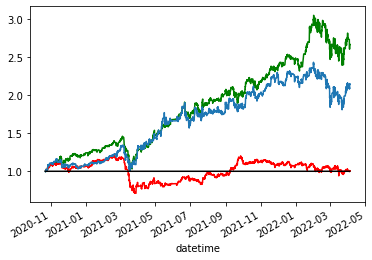

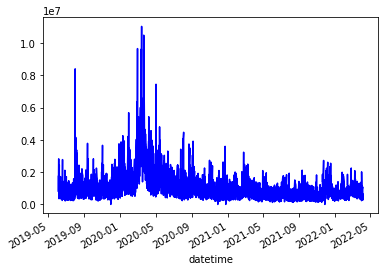

In [ ]:
por_foyo_a_c['PFn'].plot(color='green')
por_foyo_c_c['PFn'].plot(color='red')
por_foyo__c['PFn'].plot()
por_foyo__c['zero'].plot(color='black')
plt.show()
warnings.filterwarnings('ignore')
data_AAPL['volume'].plot(color='blue')

warnings.filterwarnings('ignore')

**Remarque :** Mais qu'est-ce qui s'est passé en Mars 2021 ?

### La division des examens de la SEC annonce les priorités d'examen pour 2021

**Un accent accru sur les risques liés au climat**

Le 3 Mars 2021 - La Division of Examinations de la Securities and Exchange Commission a annoncé aujourd'hui ses priorités d'examen pour 2021, notamment un accent accru sur les risques liés au climat. La Division se concentrera également sur les conflits d'intérêts pour les courtiers (Regulation Best Interest) et les conseillers en placement (obligation fiduciaire), ainsi que sur les risques connexes liés aux FinTech dans ses initiatives et examens. La Division publie chaque année ses priorités en matière d'examen afin de donner un aperçu de son approche fondée sur le risque, notamment les domaines qui, selon elle, présentent des risques potentiels pour les investisseurs et l'intégrité des marchés financiers américains. 

"Cette année, la Division met davantage l'accent sur les risques liés au climat et à l'ESG en examinant les politiques et les pratiques de vote par procuration pour s'assurer que le vote est conforme aux meilleurs intérêts et attentes des investisseurs, ainsi que les plans de continuité des activités des entreprises à la lumière de l'intensification des risques physiques liés au changement climatique", a déclaré la présidente par intérim Allison Herren Lee. "Grâce à ces efforts et à d'autres, nous intégrons les considérations climatiques et ESG dans le cadre réglementaire plus large de l'agence."

"Nos priorités reflètent la nature compliquée, diverse et évolutive des risques pour les investisseurs et les marchés, y compris le climat et l'ESG", a déclaré le directeur de la Division, Pete Driscoll. "Dans cette période sans précédent, la Division s'engage à continuer d'adapter les processus d'examen et à trouver des moyens innovants pour renforcer l'efficacité des examens et notre approche fondée sur les risques. Toutefois, les fondements de notre programme d'examen restent inchangés. Notre travail, qu'il s'agisse des examens, de la publication d'alertes sur les risques ou de la sensibilisation, sert notre mission de promotion de la conformité et de protection des investisseurs", a poursuivi M. Driscoll.




#### Définition de deux nouvelles catégories de produits présentant des caractéristiques extra-financières

Le règlement définit notamment deux catégories de produits :

*    les produits qui promeuvent des caractéristiques environnementales et/ou sociales  et ;
*    les produits qui ont pour objectif l’investissement durable .


### La SEC annonce la création d'un groupe de travail sur l'application de la loi axé sur les questions climatiques et ESG

Washington D.C., le 4 mars 2021
La Securities and Exchange Commission a annoncé aujourd'hui la création d'un groupe de travail sur le climat et les questions ESG au sein de la Division of Enforcement.  Le groupe de travail sera dirigé par Kelly L. Gibson, directeur adjoint par intérim de l'application, qui supervisera un effort à l'échelle de la division, avec 22 membres provenant du siège de la SEC, des bureaux régionaux et des unités spécialisées de l'application.

Compte tenu de l'attention et de la confiance croissantes des investisseurs dans la divulgation et l'investissement liés au climat et aux facteurs ESG, le groupe de travail sur le climat et les facteurs ESG développera des initiatives pour identifier de manière proactive les fautes liées aux facteurs ESG.  Le groupe de travail coordonnera également l'utilisation efficace des ressources de la division, y compris par l'utilisation d'une analyse de données sophistiquée pour extraire et évaluer les informations des déclarants, afin d'identifier les violations potentielles.

L'objectif initial sera d'identifier toute lacune ou inexactitude importante dans la divulgation des risques climatiques par les émetteurs en vertu des règles existantes.  Le groupe de travail analysera également les questions de divulgation et de conformité relatives aux stratégies ESG des conseillers en investissement et des fonds. Ses travaux viendront compléter les autres initiatives de l'agence dans ce domaine, notamment la récente nomination de Satyam Khanna au poste de conseiller principal en matière de politique climatique et ESG. Faisant partie intégrante des efforts de l'agence pour faire face à ces risques pour les investisseurs, le groupe de travail travaillera en étroite collaboration avec d'autres divisions et bureaux de la SEC, notamment les divisions de la finance des sociétés, de la gestion des investissements et des examens.

 "Les risques climatiques et la durabilité sont des questions cruciales pour le public investisseur et nos marchés financiers", a déclaré la présidente par intérim Allison Herren Lee. "Le groupe de travail annoncé aujourd'hui jouera un rôle important dans le renforcement et la coordination des efforts de la Division of Enforcement, du Bureau des dénonciateurs et d'autres parties de l'agence, afin de soutenir les efforts de la Commission dans son ensemble sur ces questions vitales."

"S'attaquer de manière proactive aux lacunes émergentes en matière de divulgation qui menacent les investisseurs et le marché a toujours été au cœur de la mission de la SEC", a déclaré le directeur adjoint par intérim de la Division Enforcement, Kelly L. Gibson, qui dirigera le groupe de travail. "Ce groupe de travail rassemble un large éventail d'expériences et d'expertises, ce qui nous permettra de mieux contrôler le marché, de poursuivre les fautes et de protéger les investisseurs."

En outre, le groupe de travail sur le climat et les facteurs ESG évaluera et suivra les tuyaux, les renvois et les plaintes des dénonciateurs sur les questions liées aux facteurs ESG, et fournira de l'expertise et des idées aux équipes travaillant sur les questions liées aux facteurs ESG dans toute la division.


## **Frontière efficiente**

En simule plusieurs construction de portefeuille de manière aléatoire, et on regarde le rendement vs le risque 

In [ ]:

p_ret_c = [] 
p_vol_c = [] 
p_weights_c = [] 

num_assets_c = len(por_foyo_c.columns)
num_portfolios_c = 10000

p_ret = [] 
p_vol = [] 
p_weights = [] 

num_assets = len(por_foyo.columns)
num_portfolios = 10000

p_ret_a = [] 
p_vol_a = [] 
p_weights_a = [] 

num_assets_a = len(por_foyo_a.columns)
num_portfolios_a = 10000



for portfolio in range(num_portfolios):
    weights = np.random.random(num_assets)
    weights = weights/np.sum(weights)
    p_weights.append(weights)
    returns = (np.dot(weights, ind_er)) 
                                      
    p_ret.append(returns)
    var = cov.mul(weights, axis=0).mul(weights, axis=1).sum().sum()
    sd = np.sqrt(var)
    ann_sd = sd
    p_vol.append(ann_sd)



for portfolio in range(num_portfolios_c):
    weights = np.random.random(num_assets_c)
    weights = weights/np.sum(weights)
    p_weights_c.append(weights)
    returns = (np.dot(weights, ind_er_c) )
                                      
    p_ret_c.append(returns)
    var = cov.mul(weights, axis=0).mul(weights, axis=1).sum().sum()
    sd = np.sqrt(var) 
    ann_sd = sd
    p_vol_c.append(ann_sd)


for portfolio in range(num_portfolios_a):
    weights = np.random.random(num_assets_a)
    weights = weights/np.sum(weights)
    p_weights_a.append(weights)
    returns = (np.dot(weights, ind_er_a)) 
                                      
    p_ret_a.append(returns)
    var = cov.mul(weights, axis=0).mul(weights, axis=1).sum().sum()
    sd = np.sqrt(var) 
    ann_sd = sd
    p_vol_a.append(ann_sd)

In [ ]:
data = {'Returns':p_ret, 'Volatility':p_vol}

for counter, symbol in enumerate(por_foyo.columns.tolist()):
    #print(counter, symbol)
    data[symbol+' weight'] = [w[counter] for w in p_weights]
portfolios  = pd.DataFrame(data)

data_c = {'Returns':p_ret_c, 'Volatility':p_vol_c}

for counter, symbol in enumerate(por_foyo_c.columns.tolist()):
    #print(counter, symbol)
    data_c[symbol+' weight'] = [w[counter] for w in p_weights_c]
portfolios_c  = pd.DataFrame(data_c)


data_a = {'Returns':p_ret_a, 'Volatility':p_vol_a}

for counter, symbol in enumerate(por_foyo_a.columns.tolist()):
    #print(counter, symbol)
    data_a[symbol+' weight'] = [w[counter] for w in p_weights_a]
portfolios_a  = pd.DataFrame(data_a)

#portfolios.head()

In [ ]:
min_vol_port = portfolios.iloc[portfolios['Volatility'].idxmin()]
min_vol_port_a = portfolios_a.iloc[portfolios_a['Volatility'].idxmin()]
min_vol_port_c = portfolios_c.iloc[portfolios_c['Volatility'].idxmin()]

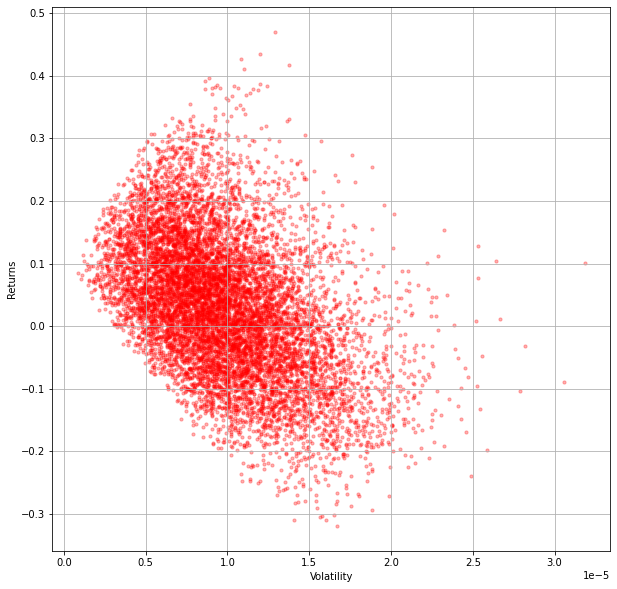

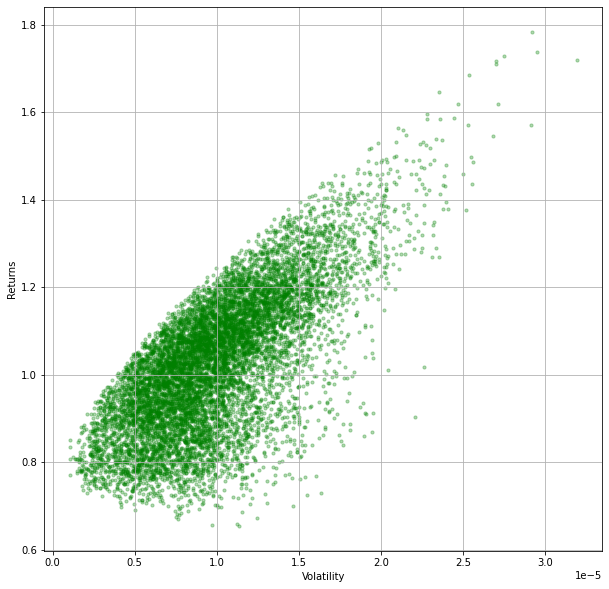

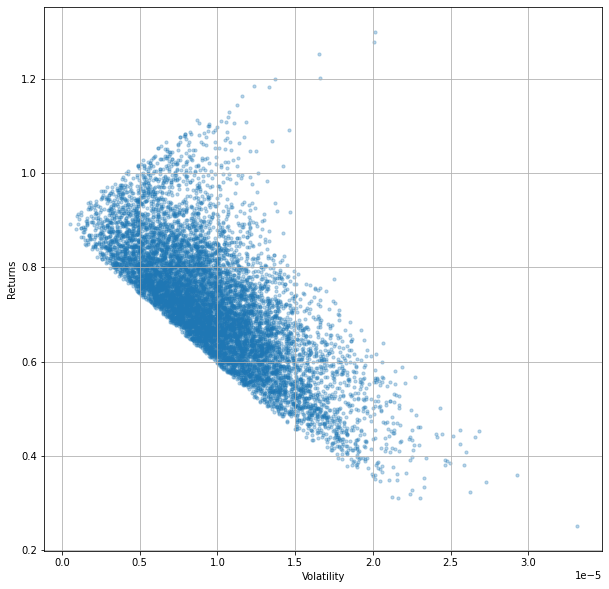

In [ ]:
from matplotlib import colors
portfolios_c.plot.scatter(x='Volatility', y='Returns',c='r', marker='o', s=10, alpha=0.3, grid=True, figsize=[10,10])
portfolios_a.plot.scatter(x='Volatility', y='Returns',c='g', marker='o', s=10, alpha=0.3, grid=True, figsize=[10,10])
portfolios.plot.scatter(x='Volatility', y='Returns', marker='o', s=10, alpha=0.3, grid=True, figsize=[10,10])

In [ ]:
rf =1  # risk free 
optimal_risky_port = portfolios.iloc[((portfolios['Returns']-rf)/portfolios['Volatility']).idxmax()]


optimal_risky_port_a = portfolios_a.iloc[((portfolios_a['Returns']-rf)/portfolios_a['Volatility']).idxmax()]


optimal_risky_port_c = portfolios_c.iloc[((portfolios_c['Returns']-rf)/portfolios_c['Volatility']).idxmax()]


In [ ]:
min_vol_port

Returns             8.924175e-01
Volatility          4.988177e-07
data_FB weight      1.484297e-01
data_AMZN weight    2.564749e-01
data_NFLX weight    4.393243e-02
data_AAPL weight    2.528340e-01
data_GOOG weight    2.983289e-01
Name: 9664, dtype: float64

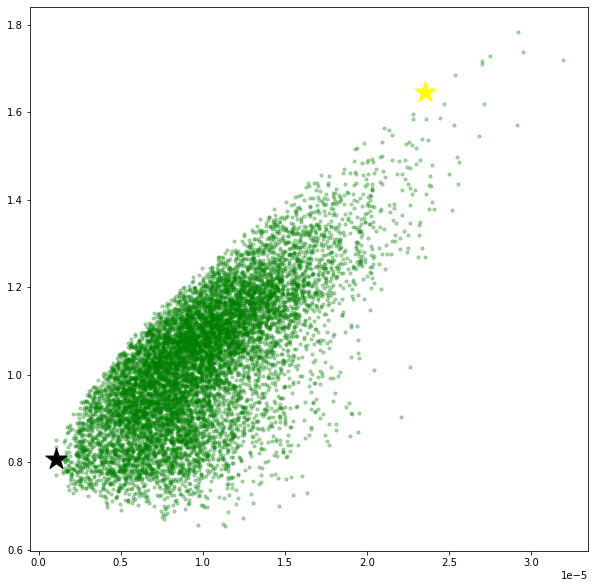

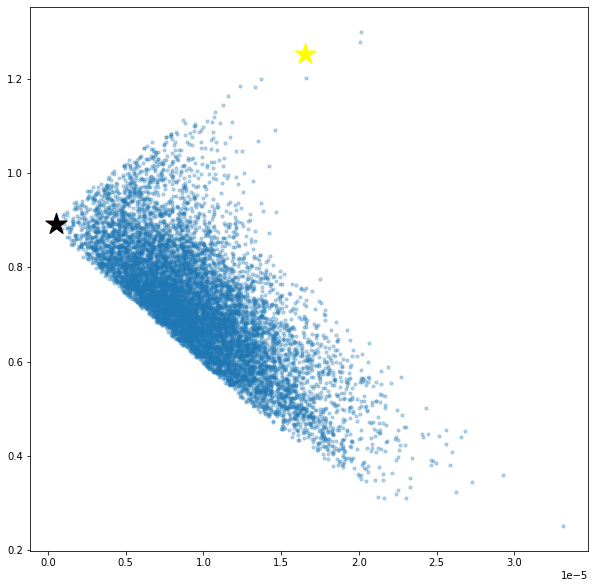

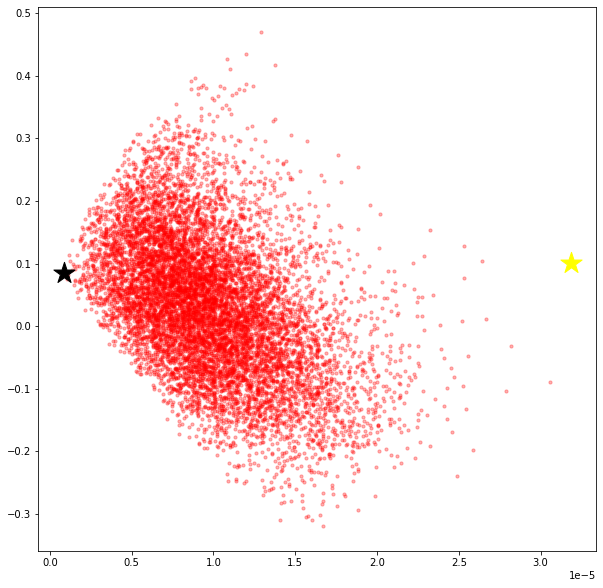

In [ ]:
plt.subplots(figsize=(10, 10))
plt.scatter(portfolios_a['Volatility'], portfolios_a['Returns'],marker='o', s=10, alpha=0.3,color='green')
plt.scatter(min_vol_port_a[1], min_vol_port_a[0], color='black', marker='*', s=500)
plt.scatter(optimal_risky_port_a[1], optimal_risky_port_a[0], color='Yellow', marker='*', s=500)

plt.subplots(figsize=(10, 10))
plt.scatter(portfolios['Volatility'], portfolios['Returns'],marker='o', s=10, alpha=0.3)
plt.scatter(min_vol_port[1], min_vol_port[0], color='black', marker='*', s=500)
plt.scatter(optimal_risky_port[1], optimal_risky_port[0], color='Yellow', marker='*', s=500)



plt.subplots(figsize=(10, 10))
plt.scatter(portfolios_c['Volatility'], portfolios_c['Returns'],marker='o', s=10, alpha=0.3,color='red')
plt.scatter(min_vol_port_c[1], min_vol_port_c[0], color='black', marker='*', s=500)
plt.scatter(optimal_risky_port_c[1], optimal_risky_port_c[0], color='Yellow', marker='*', s=500)

# **Conclusion** 
Suivre les indicateurs ESG est une bonne stratégie 
